In [ ]:
#standard package
import csv
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity, euclidean_distances
import math
from sklearn.metrics import mean_squared_error, r2_score, roc_auc_score, average_precision_score, f1_score, precision_recall_curve, roc_curve

import torch
from transformers import AutoTokenizer, AutoModel
from transformers import BertModel, BertTokenizer
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import torch.optim as optim
from torchsummary import summary

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import math
from tqdm.auto import tqdm



In [ ]:
def create_dict_from_csv(file_path):
    result_dict = {}
    All_id = []
    All_features =[]
    with open(file_path, mode='r', newline='', encoding='utf-8') as csvfile:
        reader = csv.reader(csvfile)
        for row in reader:
            if len(row) >= 2:
                cid = row[0].strip()
                feature = row[1].strip()
                result_dict[cid] = feature
                All_id.append(cid)
                All_features.append(feature)
    return result_dict, All_id, All_features


In [ ]:
Drug_Data, Drug_cid,Drug_Smiles=create_dict_from_csv('drug_info.csv')
Drug_cid = Drug_cid[1:]
Drug_Smiles =Drug_Smiles[1:]
Smiles_lenght =[]
for Smile in Drug_Smiles:
   Smiles_lenght.append(len(Smile))
print("max Smiles lenght=", np.max(Smiles_lenght))

NUM_Drugs= len(Drug_Smiles)
print(Drug_cid[0],':',Drug_Smiles[0])


Protein_Data, Protein_name, Protein_AA=create_dict_from_csv('prot_info.csv')
Protein_name = Protein_name[1:]
Protein_AA =Protein_AA[1:]
AAs_lenght = []
for AA in Protein_AA:
   AAs_lenght.append(len(AA))
print("max AA lenght=", np.max(AAs_lenght))
NUM_Protein= len(Protein_AA)
print(Protein_name[0],':',Protein_AA[0])

print('Number of Drugs=', NUM_Drugs, 'Number of Proteins=', NUM_Protein)


max Smiles lenght= 106
11485656 : CC1=CC(=C(C=C1)F)NC(=O)NC2=CC=C(C=C2)C3=C4C(=CC=C3)NN=C4N
max AA lenght= 2549
AAA61480.1|CLK1|CLK1 : MRHSKRTYCPDWDDKDWDYGKWRSSSSHKRRKRSHSSAQENKRCKYNHSKMCDSHYLESRSINEKDYHSRRYIDEYRNDYTQGCEPGHRQRDHESRYQNHSSKSSGRSGRSSYKSKHRIHHSTSHRRSHGKSHRRKRTRSVEDDEEGHLICQSGDVLSARYEIVDTLGEGAFGKVVECIDHKAGGRHVAVKIVKNVDRYCEAARSEIQVLEHLNTTDPNSTFRCVQMLEWFEHHGHICIVFELLGLSTYDFIKENGFLPFRLDHIRKMAYQICKSVNFLHSNKLTHTDLKPENILFVQSDYTEAYNPKIKRDERTLINPDIKVVDFGSATYDDEHHSTLVSTRHYRAPEVILALGWSQPCDVWSIGCILIEYYLGFTVFPTHDSKEHLAMMERILGPLPKHMIQKTRKRKYFHHDRLDWDEHSSAGRYVSRACKPLKEFMLSQDVEHERLFDLIQKMLEYDPAKRITLREALKHPFFDLLKKSI
Number of Drugs= 72 Number of Proteins= 442


In [ ]:
def kmer_tokenize(sequences, k=2):
    """
    Convert sequences into overlapping k-mers with stride 1.

    Args:
        sequences (list of str): List of amino acid sequences.
        k (int): k-mer size (2 in your case).

    Returns:
        list of str: sequences transformed into space-separated k-mers.
    """
    kmer_seqs = []
    for seq in sequences:
        kmers = [seq[i:i+k] for i in range(len(seq) - k + 1)]
        kmer_seqs.append(" ".join(kmers))
    return kmer_seqs


In [ ]:
def protein_embedding(protein_sequences):
    """
    Embed a list of protein sequences (strings of amino acids) using ProtBert.

    Args:
        protein_sequences (list of str): List of protein amino acid sequences.

    Returns:
        embeddings (torch.Tensor): Embeddings of shape (batch_size, sequence_length, hidden_size).
    """

    torch.cuda.empty_cache()

    # Load the ProtBert tokenizer and mode
    model_name = "Rostlab/prot_bert" #"facebook/esm2_t6_8M_UR50D"
    tokenizer = AutoTokenizer.from_pretrained(model_name, do_lower_case=False)
    model = AutoModel.from_pretrained(model_name)


    # Move model to GPU if available
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)
    #model.eval()

    max_seq_len = 1024

    processed_sequences = []
    for seq in protein_sequences:
        seq_truncated = seq[:max_seq_len] # Apply truncation here
        #processed_sequences.append(seq_truncated)
        processed_sequences.append(" ".join(list(seq_truncated)))

    #processed_sequences=kmer_tokenize(processed_sequences, k=2)
    batch_size = 8
    all_embeddings =[]
    num_Batches = math.ceil(NUM_Protein/batch_size)
    print(num_Batches)
    # Iterate through sequences in batches
    for i in tqdm(range(0, len(processed_sequences), batch_size), desc="Processing Batches"):
         #print(i)
         batch_sequences = processed_sequences[i:i + batch_size]
         # Tokenize the entire batch
         # padding='longest': Pads to the length of the longest sequence in the current batch.
         # truncation=True: Truncates sequences if they exceed the tokenizer's max input length (or max_seq_len if specified).
         inputs = tokenizer(batch_sequences,return_tensors="pt",padding='max_length', truncation=True,
                            max_length=max_seq_len).to(device)

         with torch.no_grad():
           outputs = model(**inputs)
           # Get the last hidden states (batch_size, sequence_length, hidden_size)
           batch_embeddings = outputs.last_hidden_state
           #print("Protein embeddings size =", batch_embeddings.shape)

         # Move embeddings to CPU and append to the list
         # Important: Only move to CPU if you don't need them on GPU for subsequent steps.
         # Moving to CPU frees up GPU memory.
         all_embeddings.append(batch_embeddings.cpu())

    # Concatenate all batch embeddings into a single tensor
    # This will result in a tensor of shape (total_sequences, max_length_in_batch, hidden_size)
    # where max_length_in_batch is the maximum length of a sequence in *any* batch,
    # because we padded 'longest' within each batch. If you need consistent length across ALL batches,
    # you'd need to pad to `max_seq_len` for every batch.
    final_embeddings_tensor = torch.cat(all_embeddings, dim=0)

    print(f"\nTotal protein embeddings tensor shape: {final_embeddings_tensor.shape}")
    print(f"Example of the first embedding's shape: {all_embeddings[0].shape}")
    return final_embeddings_tensor

    #---------------------------------------------------------------------------
    '''
    # Prepare the sequences by adding spaces between amino acids as required by ProtBert tokenizer
    sequences_with_spaces = [" ".join(list(seq)) for seq in protein_sequences]

    # Tokenize sequences (pads & truncates automatically)
    inputs = tokenizer(sequences_with_spaces, return_tensors="pt", padding=True).to(device)

    with torch.no_grad():
        outputs = model(**inputs)

    # Extract the last hidden state (embeddings)
    embeddings = outputs.last_hidden_state
    print("Protein embeding size=",embeddings.shape)

    return embeddings'''



Protein_full_embeddings = protein_embedding(Protein_AA)



56


Processing Batches:   0%|          | 0/56 [00:00<?, ?it/s]


Total protein embeddings tensor shape: torch.Size([442, 1024, 1024])
Example of the first embedding's shape: torch.Size([8, 1024, 1024])


In [ ]:
def drug_embedding(Drug_Smiles):
    tokenizer = AutoTokenizer.from_pretrained("DeepChem/ChemBERTa-10M-MLM")
    model = AutoModel.from_pretrained("DeepChem/ChemBERTa-10M-MLM")
    #move to gpu
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model.to(device)

    #tokenizer
    inputs = tokenizer(Drug_Smiles, return_tensors="pt", padding=True, truncation=True).to(model.device)

    with torch.no_grad():
      outputs = model(**inputs)
      #print(outputs)

    embeddings = outputs.last_hidden_state # Or pooler_output depending on your needs
    print("Drug embeding size=",embeddings.shape) # Should be (batch_size, sequence_length, hidden_size)
    return embeddings

Drug_full_embeddings = drug_embedding(Drug_Smiles)



Some weights of RobertaModel were not initialized from the model checkpoint at DeepChem/ChemBERTa-10M-MLM and are newly initialized: ['pooler.dense.bias', 'pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Drug embeding size= torch.Size([72, 89, 384])


In [ ]:
# --- 1. Read Data ---
csv_file_name ='Davis.csv'
raw_df = pd.read_csv(csv_file_name, header=None)
#print(f"\nLoaded raw CSV with shape: {raw_df.shape}")
#print("Raw CSV head:")
#print(raw_df.head())

# Extract drug CIDs from the first row (starting from the 5th column, index 4)
# Assuming the first 4 columns of the first row are empty or irrelevant for drug CIDs
drug_cids = raw_df.iloc[0, 4:].astype(str).tolist() # Convert to string to handle potential mixed types

# Extract protein identifiers from the 4th column (index 3) of rows 2 onwards (index 2 in 0-based)
# Assuming the combined ID is in the 4th column
protein_identifiers = raw_df.iloc[3:, 3].astype(str).tolist()
# Extract binding data (values start from row 2, column 4)
binding_data_matrix = raw_df.iloc[3:, 4:]

#print("CID=",drug_cids,'\n',"protein names=",protein_identifiers,'\n',binding_data_matrix)

# Convert wide format to long format
long_data = []
for p_idx, p_id in enumerate(protein_identifiers):
    for d_idx, d_cid in enumerate(drug_cids):
        binding_value = binding_data_matrix.iloc[p_idx, d_idx]
        binding_value = - math.log10(float(binding_value)/float(10**9))
        if pd.notna(binding_value): # Only include non-NaN binding values
            long_data.append({
                'drug_id': d_cid,
                'protein_name': p_id, # Using the combined protein identifier as 'protein_name'
                'binding_db': float(binding_value)
            })
        else :
            long_data.append({
                'drug_id': d_cid,
                'protein_name': p_id, # Using the combined protein identifier as 'protein_name'
                'binding_db': float(5.0) #-log10(10000/10^9)
            })

#print (long_data)
df_interactions = pd.DataFrame(long_data)
print(f"\nTransformed to long format DataFrame with {len(df_interactions)} interactions.")
print("First 5 rows of transformed interaction data:")
print(df_interactions.head())



Transformed to long format DataFrame with 31824 interactions.
First 5 rows of transformed interaction data:
    drug_id          protein_name  binding_db
0  11314340  AAA61480.1|CLK1|CLK1    8.853872
1  10074640  AAA61480.1|CLK1|CLK1    5.000000
2  11485656  AAA61480.1|CLK1|CLK1    5.050610
3  24889392  AAA61480.1|CLK1|CLK1    5.000000
4   6450551  AAA61480.1|CLK1|CLK1    5.000000


In [ ]:
# --- 2. Create Mappings from IDs/Names to Embedding Indices ---
# IMPORTANT ASSUMPTION: The order of drug CIDs extracted from the CSV
# matches the order of drugs in drug_full_embeddings (index 0 to 71).
# Similarly for protein identifiers and protein_full_embeddings.

drug_id_to_idx = {cid: i for i, cid in enumerate(drug_cids)}
protein_name_to_idx = {p_id: i for i, p_id in enumerate(protein_identifiers)}

# Map drug_id and protein_name in DataFrame to their respective indices
df_interactions['drug_idx'] = df_interactions['drug_id'].map(drug_id_to_idx)
df_interactions['protein_idx'] = df_interactions['protein_name'].map(protein_name_to_idx)

# Drop rows where mapping failed (if any drug_id or protein_name not found in embeddings)
df_interactions.dropna(subset=['drug_idx', 'protein_idx'], inplace=True)
df_interactions['drug_idx'] = df_interactions['drug_idx'].astype(int)
df_interactions['protein_idx'] = df_interactions['protein_idx'].astype(int)

print(f"\nAfter mapping, {len(df_interactions)} valid interactions remain.")
print("First 5 rows with mapped indices:")
print(df_interactions.head())


After mapping, 31824 valid interactions remain.
First 5 rows with mapped indices:
    drug_id          protein_name  binding_db  drug_idx  protein_idx
0  11314340  AAA61480.1|CLK1|CLK1    8.853872         0            0
1  10074640  AAA61480.1|CLK1|CLK1    5.000000         1            0
2  11485656  AAA61480.1|CLK1|CLK1    5.050610         2            0
3  24889392  AAA61480.1|CLK1|CLK1    5.000000         3            0
4   6450551  AAA61480.1|CLK1|CLK1    5.000000         4            0


In [ ]:
# --- 3. No Embedding Pooling for 2D CNN Input ---
# We will directly use the full 2D embedding matrices for drugs and proteins.
# Drug_full_embeddings: (num_drugs, drug_seq_len, drug_embed_dim) -> (72, 89, 384)
# Protein_full_embeddings: (num_proteins, protein_seq_len, protein_embed_dim) -> (442, 512, 1024)

print(f"\nUsing full 2D drug embeddings shape: {Drug_full_embeddings.shape}")
print(f"Using full 2D protein embeddings shape: {Protein_full_embeddings.shape}")



Using full 2D drug embeddings shape: torch.Size([72, 89, 384])
Using full 2D protein embeddings shape: torch.Size([442, 1024, 1024])


In [ ]:
# --- 4. Define a PyTorch Dataset Class ---
class DrugProteinDataset(Dataset):
    def __init__(self, df, drug_full_embeddings, protein_full_embeddings):
        """
        Args:
            df (pd.DataFrame): DataFrame containing 'drug_idx', 'protein_idx', and 'binding_db'.
            drug_full_embeddings (torch.Tensor): Full 2D drug embeddings (num_drugs, seq_len, embed_dim).
            protein_full_embeddings (torch.Tensor): Full 2D protein embeddings (num_proteins, seq_len, embed_dim).
        """
        self.df = df
        self.drug_embeddings_full = drug_full_embeddings
        self.protein_embeddings_full = protein_full_embeddings

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        # Get the row for the current index
        row = self.df.iloc[idx]

        # Get drug and protein indices
        drug_idx = row['drug_idx']
        protein_idx = row['protein_idx']

        # Retrieve the full 2D embedding matrices
        drug_embed_matrix = self.drug_embeddings_full[drug_idx]
        protein_embed_matrix = self.protein_embeddings_full[protein_idx]

        # Get the binding affinity value
        binding_affinity = torch.tensor(row['binding_db'], dtype=torch.float32)

        # For 2D CNN, you typically need an input channel dimension.
        # If your embeddings are already (Height, Width), a CNN expects (Channels, Height, Width).
        # We add a channel dimension of 1 if treating each as a single-channel image.
        drug_embed_matrix = drug_embed_matrix.unsqueeze(0) # Adds a channel dimension: (1, 89, 384)
        protein_embed_matrix = protein_embed_matrix.unsqueeze(0) # Adds a channel dimension: (1, 512, 1024)

        return drug_embed_matrix, protein_embed_matrix, binding_affinity


DTI_Dataset = DrugProteinDataset(df_interactions, Drug_full_embeddings, Protein_full_embeddings)
print(f"DTI Dataset have :{len(DTI_Dataset)} samples")
print(f"Example drug embedding matrix shape: {DTI_Dataset[0][0].shape}") # (1, 89, 384)
print(f"Example protein embedding matrix shape: {DTI_Dataset[0][1].shape}") # (1, 512, 1024)
print(f"Example binding affinity: {DTI_Dataset[0][2]}")

DTI Dataset have :31824 samples
Example drug embedding matrix shape: torch.Size([1, 89, 384])
Example protein embedding matrix shape: torch.Size([1, 1024, 1024])
Example binding affinity: 8.853872299194336


In [ ]:
# --- 5. Split into Train and Test Sets ---
train_size = int(0.8 * len(DTI_Dataset)) # 80% for training
test_size = len(DTI_Dataset) - train_size # Remaining for testing

train_dataset, test_dataset = random_split(DTI_Dataset, [train_size, test_size])

print(f"\nTrain set size: {len(train_dataset)} samples")
print(f"Test set size: {len(test_dataset)} samples")


# --- 6. Create PyTorch DataLoaders ---
batch_size_loader = 8 # Adjust based on your GPU memory. Keep it smaller for larger inputs.

train_loader = DataLoader(train_dataset, batch_size=batch_size_loader, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size_loader, shuffle=False)

print(f"\nTrain DataLoader created with batch size {batch_size_loader}.")
print(f"Test DataLoader created with batch size {batch_size_loader}.")



Train set size: 25459 samples
Test set size: 6365 samples

Train DataLoader created with batch size 8.
Test DataLoader created with batch size 8.


In [ ]:
# --- 7. Define the 2D CNN Model in PyTorch ---
class DrugProteinCNN(nn.Module):
  def __init__(self,drug_input_shape, protein_input_shape):
    super(DrugProteinCNN, self).__init__()

    # Drug Branch CNN
    # Input shape: (Batch_size, 1, 89, 384)
    self.drug_cnn = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)), # Output: (Batch, 32, 44, 192) approx
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)), # Output: (Batch, 64, 22, 96) approx
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)), # Output: (Batch, 128, 11, 43) approx
        nn.AvgPool2d(kernel_size= (2,2))
        )
    # Calculate the flattened size after drug CNN
    # We need to pass a dummy tensor to determine the output size
    dummy_drug_input = torch.randn(1, *drug_input_shape) # (1, 1, 89, 384)
    dummy_drug_output = self.drug_cnn(dummy_drug_input)
    self.drug_flatten_size = dummy_drug_output.shape[1] * dummy_drug_output.shape[2] * dummy_drug_output.shape[3]
    print(f"Drug CNN flattened size: {self.drug_flatten_size}")

    # Protein Branch CNN
    # Input shape: (Batch_size, 1, 512, 1024)
    self.protein_cnn = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=8, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)), # Output: (Batch, 32, 256, 512) approx
        nn.Conv2d(in_channels=8, out_channels=16, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)), # Output: (Batch, 64, 128, 256) approx
        nn.Conv2d(in_channels=16, out_channels=32, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)), # Output: (Batch, 256, 64, 128) approx
        nn.Conv2d(in_channels=32, out_channels=64, kernel_size=(3, 3), padding='same'),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=(2, 2)), # Output: (Batch, 256, 32, 64) approx

        nn.AvgPool2d(kernel_size=(2,2))
        )
    # Calculate the flattened size after protein CNN
    dummy_protein_input = torch.randn(1, *protein_input_shape) # (1, 1, 512, 1024)
    dummy_protein_output = self.protein_cnn(dummy_protein_input)
    self.protein_flatten_size = dummy_protein_output.shape[1] * dummy_protein_output.shape[2] * dummy_protein_output.shape[3]
    print(f"Protein CNN flattened size: {self.protein_flatten_size}")

    # Fully Connected Layers for combined features
    self.fc_combined = nn.Sequential(
        nn.Linear(self.drug_flatten_size + self.protein_flatten_size, 64),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(64, 32),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(32, 1) # Output a single binding affinity value
     )

  def forward(self, drug_matrices, protein_matrices):
      # Process drug matrices
      drug_features = self.drug_cnn(drug_matrices)
      drug_features = torch.flatten(drug_features, 1) # Flatten for FC layers

      # Process protein matrices
      protein_features = self.protein_cnn(protein_matrices)
      protein_features = torch.flatten(protein_features, 1) # Flatten for FC layers

      # Concatenate features from both branches
      combined_features = torch.cat((drug_features, protein_features), dim=1)

      # Pass through fully connected layers
      output = self.fc_combined(combined_features)
      return output




In [ ]:
sample_drug_matrix, sample_protein_matrix, _ = DTI_Dataset[0]
drug_input_shape = sample_drug_matrix.shape # (1, 89, 384)
protein_input_shape = sample_protein_matrix.shape # (1, 512, 1024)


model = DrugProteinCNN(drug_input_shape, protein_input_shape)

# --- Print Model Parameters ---
print("\n--- Model Parameters ---")
total_params = 0
for name, param in model.named_parameters():
    if param.requires_grad:
        num_params = param.numel()
        print(f"Layer: {name:<50} | Shape: {str(list(param.shape)):<25} | Parameters: {num_params}")
        total_params += num_params
print(f"Total Trainable Parameters: {total_params}")
print("------------------------")

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
print(f"\nModel instantiated and moved to {device}.")
print(model)

Drug CNN flattened size: 3840
Protein CNN flattened size: 65536

--- Model Parameters ---
Layer: drug_cnn.0.weight                                  | Shape: [8, 1, 3, 3]              | Parameters: 72
Layer: drug_cnn.0.bias                                    | Shape: [8]                       | Parameters: 8
Layer: drug_cnn.3.weight                                  | Shape: [16, 8, 3, 3]             | Parameters: 1152
Layer: drug_cnn.3.bias                                    | Shape: [16]                      | Parameters: 16
Layer: drug_cnn.6.weight                                  | Shape: [32, 16, 3, 3]            | Parameters: 4608
Layer: drug_cnn.6.bias                                    | Shape: [32]                      | Parameters: 32
Layer: protein_cnn.0.weight                               | Shape: [8, 1, 3, 3]              | Parameters: 72
Layer: protein_cnn.0.bias                                 | Shape: [8]                       | Parameters: 8
Layer: protein_cnn.3.weight 


--- Starting Training ---


Epoch 1/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [1/10], Training Loss: 2.9513


Epoch 2/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [2/10], Training Loss: 1.1698


Epoch 3/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [3/10], Training Loss: 0.8961


Epoch 4/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [4/10], Training Loss: 0.8308


Epoch 5/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [5/10], Training Loss: 0.8553


Epoch 6/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [6/10], Training Loss: 0.8262


Epoch 7/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [7/10], Training Loss: 0.8028


Epoch 8/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [8/10], Training Loss: 0.7958


Epoch 9/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [9/10], Training Loss: 0.7920


Epoch 10/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [10/10], Training Loss: 0.7889


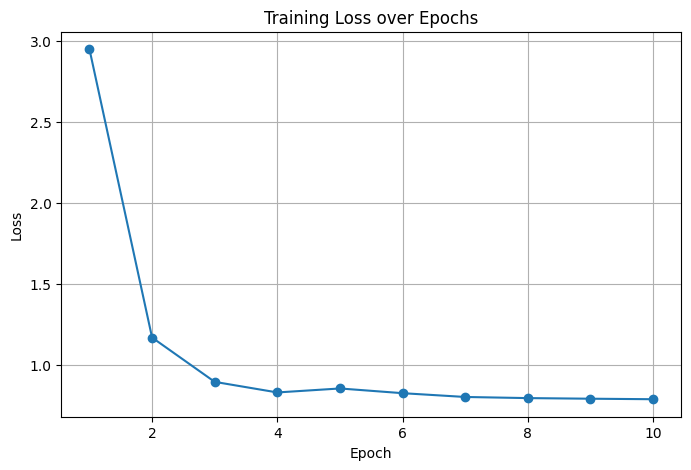


--- Starting Training ---


Epoch 1/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [1/10], Training Loss: 0.7870


Epoch 2/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

Epoch [2/10], Training Loss: 0.7865


Epoch 3/10 Training:   0%|          | 0/3183 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [ ]:
# --- 8. Training Loop ---
# Loss function for regression (Mean Squared Error)
criterion = nn.MSELoss()
# Optimizer (Adam is a good general choice)
optimizer = optim.Adam(model.parameters(), lr=0.001)

num_epochs = 10
All_epoch_loss =[]

print("\n--- Starting Training ---")
for epoch in range(num_epochs):
    model.train() # Set model to training mode
    running_loss = 0.0
    for drug_matrices, protein_matrices, targets in tqdm(train_loader, desc=f"Epoch {epoch+1}/{num_epochs} Training"):
        # Move data to the same device as the model
        drug_matrices = drug_matrices.to(device)
        protein_matrices = protein_matrices.to(device)
        targets = targets.to(device)

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        outputs = model(drug_matrices, protein_matrices)

        # Calculate loss
        loss = criterion(outputs.squeeze(), targets) # .squeeze() to remove singleton dimension from output

        # Backward pass and optimize
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * drug_matrices.size(0) # Accumulate loss

    epoch_loss = running_loss / len(train_dataset)
    All_epoch_loss.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Training Loss: {epoch_loss:.4f}")

# Plot loss curve
plt.figure(figsize=(8,5))
plt.plot(range(1, num_epochs + 1), All_epoch_loss, marker='o')
plt.title("Training Loss over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

In [ ]:
# --- 9. Evaluation ---
print("\n--- Starting Evaluation ---")
model.eval() # Set model to evaluation mode
test_loss = 0.0
predictions = []
true_values = []

with torch.no_grad(): # Disable gradient calculation for evaluation
    for drug_matrices, protein_matrices, targets in tqdm(test_loader, desc="Evaluating"):
        drug_matrices = drug_matrices.to(device)
        protein_matrices = protein_matrices.to(device)
        targets = targets.to(device)

        outputs = model(drug_matrices, protein_matrices)
        loss = criterion(outputs.squeeze(), targets)

        test_loss += loss.item() * drug_matrices.size(0)

        predictions.extend(outputs.squeeze().cpu().numpy())
        true_values.extend(targets.cpu().numpy())

final_test_loss = test_loss / len(test_dataset)
print(f"Test Loss (MSE): {final_test_loss:.4f}")

# Calculate R-squared (coefficient of determination) as another metric
from sklearn.metrics import r2_score
r2 = r2_score(true_values, predictions)
print(f"Test R-squared: {r2:.4f}")

print("\nTraining and evaluation complete!")



--- Starting Evaluation ---


Evaluating:   0%|          | 0/796 [00:00<?, ?it/s]

Test Loss (MSE): 0.7752
Test R-squared: -0.0003

Training and evaluation complete!


In [ ]:
# --- Regression-specific Concordance Index (C-index) ---
# This measures the agreement between the order of predicted values and true values.
def concordance_index(y_true, y_pred):
    y_true = np.asarray(y_true)
    y_pred = np.asarray(y_pred)

    # Filter out samples where y_true is NaN or y_pred is NaN (should be handled by dataset)
    valid_indices = ~np.isnan(y_true) & ~np.isnan(y_pred)
    y_true = y_true[valid_indices]
    y_pred = y_pred[valid_indices]

    n = len(y_true)
    if n < 2:
        return 0.0 # Not enough samples to calculate CI

    concordant_pairs = 0
    discordant_pairs = 0
    tied_pairs_pred = 0

    for i in range(n):
        for j in range(i + 1, n):
            # If true values are tied, they don't contribute to concordant/discordant pairs
            if y_true[i] == y_true[j]:
                # If predictions are also tied, count as tied in prediction
                if y_pred[i] == y_pred[j]:
                    tied_pairs_pred += 1
                continue

            # Compare predictions based on true values
            if (y_true[i] > y_true[j] and y_pred[i] > y_pred[j]) or \
               (y_true[i] < y_true[j] and y_pred[i] < y_pred[j]):
                concordant_pairs += 1
            elif (y_true[i] > y_true[j] and y_pred[i] < y_pred[j]) or \
                 (y_true[i] < y_true[j] and y_pred[i] > y_pred[j]):
                discordant_pairs += 1
            else: # Predictions are tied when true values are not
                tied_pairs_pred += 1

    total_comparable_pairs = concordant_pairs + discordant_pairs + tied_pairs_pred

    if total_comparable_pairs == 0:
        return 0.0

    ci = (concordant_pairs + 0.5 * tied_pairs_pred) / total_comparable_pairs
    return ci

ci_score = concordance_index(true_values, predictions)
print(f"Test Concordance Index (CI): {ci_score:.4f}")


# --- Classification Metrics (Require a Threshold) ---
# For AUC, AUPR, F-score, we need to convert the regression problem into a binary classification.
# You need to define a meaningful threshold for your binding affinity values.

binding_threshold = 7 #-log10(100/10^9)
print(f"\n--- Classification Metrics (using threshold={binding_threshold} for 'bound' vs 'not bound') ---")

# Convert true values and predictions to binary labels
true_binary_labels = (np.array(true_values) >= binding_threshold).astype(int)
# For predictions, we often use the raw prediction values as 'scores' for AUC/AUPR
# For F1-score, we need hard binary predictions
predicted_binary_labels = (np.array(predictions) < binding_threshold).astype(int)

# AUC (Area Under the Receiver Operating Characteristic Curve)
try:
    auc_score = roc_auc_score(true_binary_labels, predictions) # Use raw predictions as scores
    print(f"Test AUC: {auc_score:.4f}")
except ValueError as e:
    print(f"Could not calculate AUC: {e}. This might happen if all true labels are the same class.")

# AUPR (Area Under the Precision-Recall Curve)
try:
    aupr_score = average_precision_score(true_binary_labels, predictions) # Use raw predictions as scores
    print(f"Test AUPR: {aupr_score:.4f}")
except ValueError as e:
    print(f"Could not calculate AUPR: {e}. This might happen if all true labels are the same class.")

# F1-score
try:
    f1 = f1_score(true_binary_labels, predicted_binary_labels) # Use hard binary predictions
    print(f"Test F1-score: {f1:.4f}")
except ValueError as e:
    print(f"Could not calculate F1-score: {e}. This might happen if all true labels are the same class.")


print("\nTraining and evaluation complete with all requested metrics!")

Test Concordance Index (CI): 0.5000

--- Classification Metrics (using threshold=7 for 'bound' vs 'not bound') ---
Test AUC: 0.5000
Test AUPR: 0.0801
Test F1-score: 0.1484

Training and evaluation complete with all requested metrics!
